# Article Summarizer Implementation with Transformer

---

### References

This notebook was learned and modified from the assignment of the course [Natural Language Processing with Attention Models](https://www.coursera.org/learn/attention-models-in-nlp) on *Coursera* with the following amendments:

1. Instead of using a pre-trained model, I built and trained the summarizer **from scratch**

2. You can choose between 2 datasets (`multi_news` and `cnn_dailymail`)

3. I cleaned up and rewrote the part of building the Transformer model to make parameter tuning easier. The codes for the multi-head attention layer is more compact.

4. The sumarizer can be tested on the evlaution dataset or a custom article.
---

### Project Summary

After training on the cnn_dailymail dataset for 100,000 epochs, the model achieved the **accuracy of 36%** on the test set.

---
### The Reformer Paper

A. Vaswani et al., **Attention is All You Need**

https://arxiv.org/abs/1706.03762

---

## Step 1: Install Prerequisites

### 1-1 Install Trax

In [1]:
!pip -q install trax

     |████████████████████████████████| 471kB 8.5MB/s 
     |████████████████████████████████| 174kB 24.2MB/s 
     |████████████████████████████████| 2.6MB 24.4MB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 1.3MB 63.9MB/s 
     |████████████████████████████████| 1.1MB 62.9MB/s 
     |████████████████████████████████| 3.6MB 44.0MB/s 
     |████████████████████████████████| 348kB 56.7MB/s 
     |████████████████████████████████| 2.9MB 64.2MB/s 
     |████████████████████████████████| 890kB 41.6MB/s 
ERROR: transformers 3.5.0 has requirement sentencepiece==0.1.91, but you'll have sentencepiece 0.1.94 which is incompatible.


### 1-2 Import Libraries

In [2]:
import sys
import os

import numpy as np

import trax

from trax import layers as tl
from trax.fastmath import numpy as fastnp
from trax.supervised import training

import matplotlib.pyplot as plt
%matplotlib inline

## Step 2: Download the dataset

### 2-1 Determine the dataset

Dataset can either be `multi_news` or `cnn_dailymail`

**multi_news**

The `multi_news` dataset is 245 MB. It contains 44,972 training data.

The articles and summaries can be loaded by calling `keys = ('documents', 'summary')`

**cnn_dailymail**

The `cnn_dailymail` dataset is ? MB. It contains ? training data.

The articles and summaries can be loaded by calling `keys = ('article', 'highlights')`

In [3]:
## Determine dataset
dataset_name = 'cnn_dailymail'

if dataset_name == 'multi_news':
    dataset_keys = ('document', 'summary')
elif dataset_name == 'cnn_dailymail':
    dataset_keys = ('article', 'highlights')


## Training stream generator
train_stream_generator = trax.data.TFDS(dataset_name, keys = dataset_keys, train = True)()

## Training stream generator
test_stream_generator = trax.data.TFDS(dataset_name, keys = dataset_keys, train = False)()

Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/3.1.0.incomplete7LU4XZ/cnn_dailymail-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/3.1.0.incomplete7LU4XZ/cnn_dailymail-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cnn_dailymail/3.1.0.incomplete7LU4XZ/cnn_dailymail-test.tfrecord


Dataset cnn_dailymail downloaded and prepared to /root/tensorflow_datasets/cnn_dailymail/3.1.0. Subsequent calls will reuse this data.


In [4]:
## Check data format
x = next(train_stream_generator)
print("Length of each data: {}".format(len(x)))
print("\nx[0]")
print(x[0])
print("\nx[1]")
print(x[1])

y = next(test_stream_generator)
print("Length of each data: {}".format(len(y)))
print("\ny[0]")
print(y[0])
print("\ny[1]")
print(y[1])
del x, y

Length of each data: 2

x[0]
b"By . Becky Barrow . PUBLISHED: . 03:39 EST, 8 May 2012 . | . UPDATED: . 18:10 EST, 8 May 2012 . Andrew Moss: He will be paid \xc2\xa380,000 a month for the next year . The boss of Britain\xe2\x80\x99s biggest insurance company will continue to receive his salary of \xc2\xa380,000 a month for the next year despite his humiliating resignation yesterday. Andrew Moss, who has quit as chief executive of Aviva after a shareholder revolt, will receive a golden goodbye worth around \xc2\xa31.75million in total. Last Thursday, 59 per cent of shareholder votes failed to back his gold-plated pay package worth up to \xc2\xa35.2million last year. It was the latest chapter in the growing backlash against boardroom greed, nicknamed the Shareholder Spring. Yesterday the 54-year-old chief executive said he \xe2\x80\x98felt it was in the best interests of the company that he step aside to make way for new leadership\xe2\x80\x99. But Mr Moss, who has also sparked public cri

## Step 3: Data Preprocessing

### 3-1 Helper functions to tokenize/detokenize

In [5]:
def tokenize(sentence):
    """
    Tokenizer

    Input  
            sentence: <str> the input sentence to be tokenized
    """
    return list(trax.data.tokenize(iter([sentence]), vocab_file = 'en_32k.subword'))[0]


def detokenize(tokens):
    """
    Detokenizer

    Input
            tokens: <list of int> a list of tokens
    """
    return trax.data.detokenize(tokens, vocab_file = 'en_32k.subword')


### 3-2 Helper function to concatenate articles and summaries

In [6]:
def concatenate_stream(stream):
    """
    Given a sample from the stream = (article, summary). Add a [1, 0] in between and an [1] in the end

    Input
            stream: the input stream = (article, summary). article and summary are list of tokens
    """
    for (article, summary) in stream:
        
        # length of the article (units: number of tokens)
        article_len = len(list(article))

        # length of the summary (units: number of tokens)
        summary_len = len(list(summary))

        # concatenate to  [article_tokens, 1, 0, summary_tokens, 1]
        concat = np.array(list(article) + [1, 0] + list(summary) + [1])

        # input weights: 0s at positions [article_tokens, 1, 0] and 1s at positions [summary_tokens, 1]
        weights = np.array([0 for _ in range(article_len + 2)] + [1 for _ in range(summary_len + 1)])

        yield concat, concat, weights

### 3-3 Data preprocess pipeline

In [7]:
MAX_DATA_LENGTH = 1024

preprocess_pipeline = trax.data.Serial(trax.data.Shuffle(),
                                       trax.data.Tokenize(vocab_file = 'en_32k.subword'),
                                       concatenate_stream,
                                       trax.data.FilterByLength(MAX_DATA_LENGTH),
                                       trax.data.BucketByLength(boundaries = [128, 256, 512, 1024], batch_sizes = [16, 8, 4, 2, 1]))

train_stream = preprocess_pipeline(train_stream_generator)
test_stream = preprocess_pipeline(test_stream_generator)

In [8]:
## check
np.set_printoptions(threshold = sys.maxsize)

x, _, y = next(train_stream)
print("input.shape = {}".format(x.shape))
print("weights.shape = {}".format(y.shape))
print("\nInput:")
print(x[0])
print("\nWeights:")
print(y[0])

assert len(x[0]) == len(y[0])
print("\nLengths of input and mask are consistent")

print("\nArticle:")
a = x[0][y[0] == 0]
print(trax.data.detokenize(a, vocab_file = 'en_32k.subword'))

print("\nSummary:")
s = x[0][y[0] == 1]
print(trax.data.detokenize(s, vocab_file = 'en_32k.subword'))

del x, y, a, s

np.set_printoptions(threshold = None)

input.shape = (2, 1024)
weights.shape = (2, 1024)

Input:
[11387   301   120 16063  2053   231  5610    65     2  2448  3505  8130
    21   837 16063    20   284     6 15699   120   590  6164     2 11305
  5610 16063    65   415 11419  1730     2  9066  1720    43  2499  2914
    18 24215    18    75 15384   490    76  2194   255    10    54   895
    18   194    43     2 11305    50  1750     2    76   756    35     2
  7315    21    27 21544     3  1129   141   512   470     2  9486   513
  8369     8  9810 13479   895    18  5886    76  7577    35     2  9793
  1720    21 17678     3  4174    60 11387   301  6164   216   120 16063
  5610   194    23  1750  2053   231    35    93    44    18  5886 13122
    23     2    76  9793  6902 19842     3    27 10013   334    46   379
    43 24534  9624    65     2 10521 10454  5783    14  2006  1232     6
   198  6164     2  5610  6504  2155    43  9717  1588   147  1720    51
  1061 14452  1652    23 22515   645     2 17196  9364  1004    21

## Step 4: Build the Transformer from scratch

### 4-1 Multi-Head Attention (MHA)

In [9]:
def MHA(d_model, n_heads, mode = 'train'):

    """
    Multi-Head Attention

    Inputs
            d_model: <int> dimension of input embedding
            n_heads: <int> number of heads of each layer of mha
            mode: <str> 'train', 'eval', or 'predict'

    Output
    """

    # make sure d_model / n_head = d_k is an integer
    assert d_model % n_heads == 0
    d_k = d_model // n_heads

    def mha_input_func(x):
        """
        The function to reshape the input tensor x
        """
        # the batch_size
        batch_size= x.shape[0]
        # the input sequence length
        seq_len = x.shape[1]
        # reshape: (batch_size, seq_len, d_model) --> (batch_size, seq_len, n_heads, d_k)
        x = fastnp.reshape(x, (batch_size, seq_len, n_heads, d_k))
        # transpose: (batch_size, seq_len, n_heads, d_k) --> (batch_size, d_k, seq_len, n_heads)
        x = fastnp.transpose(x, (0, 2, 1, 3))
        # reshape: (batch_size, d_k, seq_len, n_heads) --> (batch_size * n_heads, seq_len, d_k)
        x = fastnp.reshape(x, (batch_size * n_heads, seq_len, d_k))
        return x
    
    def mha_attention_func(Q, K, V):
        """
        Calculate the attention, given (query, key, value) = (Q, K, V)
        """
        # the size of the mask
        mask_size = Q.shape[1]
        # create the mask (M)
        M = fastnp.tril(fastnp.ones((1, mask_size, mask_size), dtype = fastnp.bool_))
        # calculate the scaled dot-product
        scaled_dot_product = fastnp.matmul(Q, fastnp.swapaxes(K, 1, 2)) / fastnp.sqrt(d_k)
        # apply mask
        if M is not None:
            scaled_dot_product = fastnp.where(M, scaled_dot_product, fastnp.full_like(scaled_dot_product, -1e9))
        # softmax
        softmax_scaled_dot_product = fastnp.exp(scaled_dot_product - trax.fastmath.logsumexp(scaled_dot_product, axis = -1, keepdims = True))
        # matmul with V
        attention = fastnp.matmul(softmax_scaled_dot_product, V)
        return attention
        
    def mha_output_func(x):
        """
        The function to reshape the output tensor x of the attention
        x.shape = (batch_size * n_heads, seqlen, d_head)
        """
        # the sequence length
        seq_len = x.shape[1]
        # reshape: (batch_size * n_heads, seqlen, d_head) --> (batch_size, n_heads, seq_len, d_k)
        x = fastnp.reshape(x, (-1, n_heads, seq_len, d_k))
        # transpose: (batch_size, n_heads, seq_len, d_k) --> (batch_size, seq_len, n_heads, d_k)
        x = fastnp.transpose(x, (0, 2, 1, 3))
        # reshape: (batch_size, seq_len, n_heads, d_k) --> (batch_size, seq_len, n_heads * d_k)
        x = fastnp.reshape(x, (-1, seq_len, n_heads * d_k))
        return x

    ## Convert functions to layers
    mha_input_layer = tl.Fn("mha_input", mha_input_func, n_out = 1)
    mha_attention_layer = tl.Fn("mha_attention", mha_attention_func, n_out = 1)
    mha_output_layer = tl.Fn("mha_output", mha_output_func, n_out = 1)

    ## MHA layer
    MHA_layer = tl.Serial(tl.Branch([tl.Dense(d_model), mha_input_layer],
                                    [tl.Dense(d_model), mha_input_layer],
                                    [tl.Dense(d_model), mha_input_layer]),
                          mha_attention_layer,
                          mha_output_layer,
                          tl.Dense(d_model))
    
    return MHA_layer

In [10]:
## Check
print(MHA(512, 8, mode = 'train'))

Serial[
  Branch_out3[
    [Dense_512, mha_input]
    [Dense_512, mha_input]
    [Dense_512, mha_input]
  ]
  mha_attention_in3
  mha_output
  Dense_512
]


### 4-2 Single Decoder Layer

In [11]:
def DecoderLayer(d_model, d_ff, n_heads, dropout_rate, mode, ff_activation):

    """
    Create a single decoder layer

    Inputs
            d_model: <int> the dimenstion of embedding
            d_ff: <int> number of units in the feed-forward dense layer
            n_heads: <int> number of heads of attention
            dropout_rate: <float> the rate of dropout
            mode: <str> 'train' or 'eval' or 'predict'
            ff_activation: <trax layer> the feed-forward activation layer
    """

    ## Multi-Head Attention
    Multihead_Attention = MHA(d_model, n_heads, mode)

    ## Feed-Forward Block
    Feed_Forward_Block = [tl.LayerNorm(),
                          tl.Dense(d_ff),
                          ff_activation(),
                          tl.Dropout(rate = dropout_rate, mode = mode),
                          tl.Dense(d_model),
                          tl.Dropout(rate = dropout_rate, mode = mode)]
    
    ## Decoder Layer
    decoder_layer = [tl.Residual(tl.LayerNorm(),
                                 Multihead_Attention,
                                 tl.Dropout(rate = dropout_rate, mode = mode)),
                     tl.Residual(Feed_Forward_Block)]

    return decoder_layer

In [12]:
## Check
print(DecoderLayer(512, 2048, 8, 0.1, 'train', tl.Relu))

[Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Serial[
        Branch_out3[
          [Dense_512, mha_input]
          [Dense_512, mha_input]
          [Dense_512, mha_input]
        ]
        mha_attention_in3
        mha_output
        Dense_512
      ]
      Dropout
    ]
  ]
  Add_in2
], Serial[
  Branch_out2[
    None
    Serial[
      LayerNorm
      Dense_2048
      Relu
      Dropout
      Dense_512
      Dropout
    ]
  ]
  Add_in2
]]


### 4-3 Complete Transformer

In [13]:
def TransformerLM(vocab_size = 33000, d_model = 512, d_ff = 2048, n_layers = 6, n_heads = 8,
                  dropout_rate = 0.1, max_len = 2*MAX_DATA_LENGTH, mode = 'train', ff_activation = tl.Relu):
    
    """
    Create the Transformer model

    Inputs
            vocab_size: <int> size of the vocabulary
            d_model: <int> dimensiton of embedding
            d_ff: <int> number of units of the feed-forward layer
            n_layer: <int> number of encoder/decoder layers
            n_heads: <int> number of attention heads
            dropout_rate: <float> rate of dropout layer
            max_len: <int> max length for positional encoding
            mode: <str> 'train', 'eval', or 'predict'
            ff_activation: <trax layer> the activation layer of the feed-forward layer
    """
    
    ## Positional Encoding
    Positional_Encoder = [tl.Embedding(vocab_size = vocab_size, d_feature = d_model),
                          tl.Dropout(rate = dropout_rate, mode = mode),
                          tl.PositionalEncoding(max_len = max_len, mode = mode)]
    
    ## Decoder
    Transformer_Decoder = [DecoderLayer(d_model, d_ff, n_heads, dropout_rate, mode, ff_activation) for _ in range(n_layers)]

    ## Transformer model
    model = tl.Serial(tl.ShiftRight(mode = mode),
                      Positional_Encoder,
                      Transformer_Decoder,
                      tl.LayerNorm(),
                      tl.Dense(vocab_size),
                      tl.LogSoftmax())
    
    return model

In [14]:
## Check
print(TransformerLM(n_layers = 2))

Serial[
  Serial[
    AssertShape
    ShiftRight(1)
    AssertShape
  ]
  Embedding_33000_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Branch_out3[
            [Dense_512, mha_input]
            [Dense_512, mha_input]
            [Dense_512, mha_input]
          ]
          mha_attention_in3
          mha_output
          Dense_512
        ]
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Relu
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Branch_out3[
            [Dense_512, mha_input]
            [Dense_512, mha_input]
            [Dense_512, mha_input]
          ]
          mha_attention_in3
          mha_output
          Dense_512
        ]
        Dropout
      ]
    ]
    Add

## Step 5: Train the Transformer

### 5-1 Define Loop

| d_model | d_ff | n_layers | Acc (20k) | Acc (50k) | Acc (100k) |
|---|---|---|---|---|---|
| 128 | 512 | 2 | ? | ? | ? |
| 256 | 512 | 2 | ? | ? | ? |
| 128 | 512 | 4 | ? | ? | ? |
| 128 | 1024 | 2 | 0.262| 0.405 | 0.369 |
| 256 | 512 | 4 |0.303| 0.318 | ? |
| 512 | 1024 | 4 | 0.143 | 0.245 | ? |
| 512 | 512 | 6 | 0.193 | 0.272 | 0.360 |
| 512 | 1024 | 6 | 0.164 | 0.271 | 0.250 |

In [57]:
def create_loop(TransformerLM, train_generator, eval_generator, d_model = 512, d_ff = 2048, n_layers = 6, n_warmup_steps = 4000, max_value_scaling = 1.0):

    """
    Create the loop object

    Inputs
            TransformerLM: <trax model> the Transformer model
            train-train_generator: <trax stream> the training stream
            eval_generator: <trax stream> the evaluation stream
            d_model: <int> dimension of embedding
    """

    ## Learning rate schedule
    max_value = max_value_scaling/np.sqrt(d_model*n_warmup_steps)
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps = n_warmup_steps, max_value = max_value)

    ## traing task
    train_task = training.TrainTask(labeled_data = train_generator,
                                    loss_layer = tl.CrossEntropyLoss(),
                                    optimizer = trax.optimizers.Adam(max_value),
                                    lr_schedule = lr_schedule,
                                    n_steps_per_checkpoint = 10000)

    ## plot lr_schedule
    steps = []
    lrs = []
    for i in range(1,100000+1):
        if i % 100 == 1:
            steps.append(i)
            lrs.append(float(train_task.learning_rate(i)))

    plt.figure()
    plt.plot(steps, lrs)
    plt.title("lr schedule")
    plt.show()

    ## evaluation task
    eval_task = training.EvalTask(labeled_data = eval_generator,
                                  metrics = [tl.CrossEntropyLoss(), tl.Accuracy()])
    
    ## create the loop object
    # parameters of the original paper: d_model = 512, d_ff = 2048, n_layers = 6, n_heads = 8, dropout_rate = 0.1

    loop = training.Loop(TransformerLM(vocab_size = 33000,
                                       d_model = d_model,
                                       d_ff = d_ff,
                                       n_layers = n_layers,
                                       n_heads = 8,
                                       dropout_rate = 0.1,
                                       max_len = 2*MAX_DATA_LENGTH,
                                       mode = 'train',
                                       ff_activation = tl.Relu),
                         train_task,
                         eval_tasks = [eval_task],
                         output_dir = '.')
    
    return loop

In [59]:
## This box needs to be executed if training_loop has been run before
!rm model.pkl.gz
!rm config.gin
!rm -r train
!rm -r eval

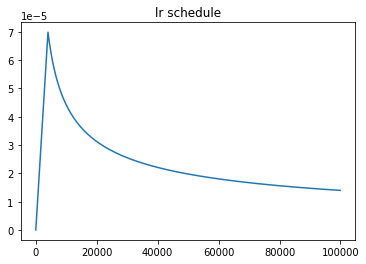

In [58]:
loop = create_loop(TransformerLM, train_stream, test_stream, d_model = 512, d_ff = 1024, n_layers = 6, n_warmup_steps = 4000, max_value_scaling = 0.1)

In [60]:
loop.run(100000)


Step  410000: Ran 10000 train steps in 752.92 secs
Step  410000: train CrossEntropyLoss |  2.65430570
Step  410000: eval  CrossEntropyLoss |  2.81403160
Step  410000: eval          Accuracy |  0.60992908

Step  420000: Ran 10000 train steps in 683.06 secs
Step  420000: train CrossEntropyLoss |  2.76288652
Step  420000: eval  CrossEntropyLoss |  3.87202978
Step  420000: eval          Accuracy |  0.37419355

Step  430000: Ran 10000 train steps in 687.89 secs
Step  430000: train CrossEntropyLoss |  2.89239478
Step  430000: eval  CrossEntropyLoss |  2.93339944
Step  430000: eval          Accuracy |  0.58469945

Step  440000: Ran 10000 train steps in 686.85 secs
Step  440000: train CrossEntropyLoss |  2.99948788
Step  440000: eval  CrossEntropyLoss |  3.10649848
Step  440000: eval          Accuracy |  0.56521738

Step  450000: Ran 10000 train steps in 688.12 secs
Step  450000: train CrossEntropyLoss |  3.10495377
Step  450000: eval  CrossEntropyLoss |  2.57429194
Step  450000: eval        

## Step 6: Evaluation

### 6-1 Helper Function to determine the next token

In [26]:
def generate_next_token(current_tokens, model):

    """
    Generate the next token
    
    Inputs
            current_tokens: <list of int> currently generated token so far
            model: <trax model> the model for the prediction
    
    Output
            next_token: <int> the next token generated by the model
    """

    # number of tokens generated so far
    current_tokens_length = len(current_tokens)
    
    # find the next power of 2 to be the final length after padding
    final_padded_length = 2**int(np.ceil(np.log2(current_tokens_length + 1)))

    # caucluate the number of zeros to pad
    to_pad_length = final_padded_length - current_tokens_length

    # pad 0s, convert to ndarry, and add a batch dimension of at axis = 0
    padded_current_tokens = np.array(current_tokens + [0 for _ in range(to_pad_length)])[None, :]

    # use the model to predict the log probabilities of the next token
    model_output, _ = model((padded_current_tokens, padded_current_tokens))

    # (note) model_output has shape (batch_size, len_of_whole_token_list, vocab_size)
    # only take the log probability distribution of the last token
    next_token_logprob = model_output[0, current_tokens_length, :]

    # select the token with the largest log probability
    next_token = int(np.argmax(next_token_logprob))

    return next_token


### 6-2 The summarizer

In [27]:
def summarize(article, model):

    """
    Summarize the article

    Inputs 
            article: <str> the article
            model: <trax model> the summarizer model

    Output
            summary: <str> the summary
    """

    current_tokens = tokenize(article).tolist() + [1, 0]

    generated_summary_tokens = []

    last_output_token = 0

    while last_output_token != 1:
        next_output_token = generate_next_token(current_tokens, model)
        current_tokens.append(next_output_token)
        generated_summary_tokens.append(next_output_token)
        last_output_token = next_output_token

        if len(current_tokens) == 4096:
            break

    summary = trax.data.detokenize(generated_summary_tokens, vocab_file = 'en_32k.subword')

    return summary


### 6-3 Summarize an article

In [39]:
## Load the model

article_summarizer = loop.model
article_summarizer.mode = "predict"

#### 5-3-1 Predict on the training dataset

In [61]:
test_sample = next(train_stream_generator)

test_article = test_sample[0]
test_summary = test_sample[1]

if len(tokenize(test_article)) >= 2*MAX_DATA_LENGTH:
    print("input too long")
else:
    print("article:")
    print(test_article)

    print("\nactual summary:")
    print(test_summary)

    print("\npredict summary:")
    print(summarize(test_article, article_summarizer))

article:
b"By . David Mccormack . PUBLISHED: . 09:02 EST, 26 September 2013 . | . UPDATED: . 12:44 EST, 26 September 2013 . A 16-year-old cheerleader with Down syndrome was called a liability by school officials in Deer Park, Texas, and prevented from joining the rest of her squad pitch-side on Tuesday night. Brittany Davila, a freshman at Deer Park High School, recently made the team as an honorary cheerleader. When she and her parents arrived for Tuesday night\xe2\x80\x99s volleyball game, school officials told them Brittany could no longer be part of the team because she was a liability. Scroll down for video . Brittany Davila, a 16-year-old cheerleader with Down syndrome, was forced to cheer from the stands on Tuesday night after school officials in Deer Park, Texas, called her a 'liability' Freshman Brittany Davila was recently made an honorary cheerleader, but she was prevented her from performing pitch-side on Tuesday night . \xe2\x80\x98Being a parent of a child with special ne

#### 5-3-2 Test dataset article

In [62]:
test_sample = next(test_stream_generator)

test_article = test_sample[0]
test_summary = test_sample[1]

if len(tokenize(test_article)) >= 2*MAX_DATA_LENGTH-3:
    print("input too long")
else:
    print("article:")
    print(test_article)

    print("\nactual summary:")
    print(test_summary)

    print("\npredict summary:")
    print(summarize(test_article, article_summarizer))

article:
b"The NFL have fined the Atlanta Falcons and stripped them of a draft pick  following the team's use of fake crowd noise at home games. In a statement released on Monday, the league announced that the Falcons have been fined $350,000 (\xc2\xa3237,000)\xc2\xa0and will forfeit their fifth-round selection in the 2016 draft. If the Falcons have multiple picks in that round, the highest selection will be forfeited. Team president Rich McKay has also been suspended from the league's Competition Committee beginning April 1. Atlanta Falcons have been fined \xc2\xa3237,000 for their use of fake crowd noise at the Georgia Dome . Owner Arthur Blank acknowledged the team's wrongdoing and described the incident as embarrassing . The NFL noted throughout the 2013 season and into the 2014 season the Falcons violated league rules that state 'at no point during the game can artificial crowd noise or amplified crowd noise be played in the stadium.' The league also said Roddy White, the team's f

#### 5-3-3 Custom article

The article below comes from a lab [website](https://neurophysics.ucsd.edu/active_sensation.php):



In [63]:
custom_article = """At the level of the brain stem, we identified the circuit responsible for generating the rhythmic pattern that drives the facial motoneurons \
and thus whisking (bottom figure). Interestingly, this structure receives input from the respiratory rhythm generator and, is fact, is reset by the onset of \
inspiration. In a second project, we identified a sensorimotor feedback pathway involved in active vibrissa contact. The results from behavioral, physiological, \
and anatomical experiments show that contact leads to a positive signal that further drives the mystacial musculature. Ultimately, the system adapts and feedback \
diminishes. In ongoing work, we seek the pathway that controls the midpoint, or posture, of the vibrissae. \n At the level of the neocortex, we identified the nature \
and origin of reference signals for vibrissa position in both primary sensory and motor cortices. These signals are essential determinates of the position of the vibrissae. \
Interestingly, neurons in primary sensory cortex code position in coordinates that are referenced to the range of motion rather than to the body axis of the animal. \
These data, together with the results of behavioral studies to demonstrate that rats with only a single vibrissa can detect the angle of contact and physiology experiments \
that demonstrates that reafferent and exafferent signals share a common pathway, define a means to merge reference and touch signals to code vibrissa position. Indeed, our \
recent shows that this merge occurs in primary sensory cortex. Ongoing work suggest that a strong nonlinear input-output relation in neurons is responsible for the merge \
similar to homodyne detection in communication."""

print("Length of tokenized input = {}".format(len(tokenize(custom_article))))
print("Ending token = {}".format(tokenize(custom_article)[-1]))

print("\nArticle:")
print(custom_article)

print("\nSummary:")
print(summarize(custom_article, article_summarizer))

Length of tokenized input = 361
Ending token = 11

Article:
At the level of the brain stem, we identified the circuit responsible for generating the rhythmic pattern that drives the facial motoneurons and thus whisking (bottom figure). Interestingly, this structure receives input from the respiratory rhythm generator and, is fact, is reset by the onset of inspiration. In a second project, we identified a sensorimotor feedback pathway involved in active vibrissa contact. The results from behavioral, physiological, and anatomical experiments show that contact leads to a positive signal that further drives the mystacial musculature. Ultimately, the system adapts and feedback diminishes. In ongoing work, we seek the pathway that controls the midpoint, or posture, of the vibrissae. 
 At the level of the neocortex, we identified the nature and origin of reference signals for vibrissa position in both primary sensory and motor cortices. These signals are essential determinates of the position